# 라임 기반의 작사 모델 - 라임 스코어

사용한 라이브러리와 오픈소스

1. hgtk : https://github.com/bluedisk/hangul-toolkit
2. googletrans : https://github.com/ssut/py-googletrans
3. request : https://github.com/psf/requests
4. 엑셀 오픈 모듈 openpyxl : https://openpyxl.readthedocs.io/en/stable/
5. 데이터 프레임 라이브러리 pandas : https://pandas.pydata.org/
6. 영어 => 한글발음 : "https://transliterator.herokuapp.com/"
7. 한국어 word2vec : https://github.com/Kyubyong/wordvectors

In [ ]:
#환경이 google colab인 경우
from google.colab import drive
drive.mount('/gdrive', force_remount= True)

In [ ]:
!pip install -r requirements.txt

In [ ]:
#필요한 라이브러리 로드

from collections import Counter
import pandas as pd
import re
import openpyxl
import requests 
import googletrans
import hgtk
import gensim
from sys import stdout

In [ ]:
#라임 스코어링에 사용할 단어 로드
#( 자주 사용되는 기본 단어 목록 + 사용할 가사 데이터)

#lyrics
#사용할 데이터 경로 지정

#=============================================================================
base = "/gdrive/My Drive/Colab Notebooks/corpus_data/corpus.xlsx"
lyrics = "/gdrive/My Drive/Colab Notebooks/corpus_data/hiphop.txt"

lyrics_xlsx_list = ["9000D","9000B","0110D","0110B","1119B","1119D"]
#=============================================================================

base_df = pd.read_excel(base, engine='openpyxl')

#기본단어 , 가사중 kor , 가사중 eng
base_word = []
lyric_word_kor = []
lyric_word_eng = []

for i in base_df.itertuples():
   x = re.sub('[^A-Za-z가-힣]', '', i.단어)
   base_word.append(x)

lydata = open(lyrics, "r", encoding='euc-kr').read().splitlines()
for i in lydata:
  split_word = list(i.split(" "))
  for word in split_word:
    if word.upper() != word.lower():
      word = re.sub('[^A-Za-z]', '', word)
      lyric_word_eng.append(word)
    else:
      word = re.sub('[^가-힣]', '', word)
      lyric_word_kor.append(word)

lyric_word_kor = list(set(lyric_word_kor))
lyric_word_eng = list(set(lyric_word_eng))

print(len(lyric_word_kor))
print(len(lyric_word_eng))


In [ ]:
#=============================================================================

lyrics_xlsx_list = ["9000D","9000B","0110D","0110B","1119B","1119D"]
base_xl = "/gdrive/My Drive/Colab Notebooks/corpus_data/"

#=============================================================================

lines = ""
for k in lyrics_xlsx_list:
  base_df_ly = pd.read_excel(base_xl+k+".xlsx", engine='openpyxl')

  for i in base_df_ly.itertuples():
    ly_line = i.lyrics
    for word in ly_line.split(" "):
      if word.upper() != word.lower():
        word = re.sub('[^A-Za-z]', '', word)
        lyric_word_eng.append(word)
      else:
        word = re.sub('[^가-힣]', '', word)
        lyric_word_kor.append(word)

lyric_word_kor = list(set(lyric_word_kor))
lyric_word_eng = list(set(lyric_word_eng))

print(len(lyric_word_kor))
print(len(lyric_word_eng))
lyric_word_eng_to_kor = {}

In [ ]:
#영어를 한글 발음으로 변환해주는 사이트를 이용
#영문 단어들에 대한 라임을 고려하기 위해 한글발음으로 변환

#영문단어를 사용하지 않는다면 실행 X

lyric_word_eng_to_kor = {}
translator = googletrans.Translator()

url = "https://transliterator.herokuapp.com/"
sess = requests.Session()

all = len(lyric_word_eng)
idx = 0

for i in lyric_word_eng:
  payload = {'input': i}
  res = sess.post(url, data = payload)
  change_kor = res.json()['output'].replace('?',' ')
  
  result = translator.translate(i, dest='ko')

  lyric_word_eng_to_kor[i] = [change_kor,result.text]
  
  progress = 100*(idx+1)/all
  stdout.write("\r ===== %d%% completed =====" % progress)
  stdout.flush()
  idx += 1
stdout.write("\n")

#딕셔너리에 영어단어 : [발음 , 의미] 로 mapping
print(lyric_word_eng_to_kor)



In [ ]:
#두 단어 사이의 hit을 매기는 함수 
#라임의 경우 모음에 치중한 경우가 많아 모음에 hit score를 더줌
#모음이 같은 경우 : +2 / 자음이 같은 경우 +1

def rhyme_score(word1, word2):
  if len(word1) > len(word2):
    swap = word1
    word1 = word2
    word2 = swap

  w1_slice = []
  w2_every = []
  for i in word1:
    a = hgtk.letter.decompose(i)
    w1_slice.append(a)

  for i in range(0,len(word2)-len(word1)+1):
    w2 = word2[i:i+len(word1)]
    w2_slice = []
    for k in w2:
      a = hgtk.letter.decompose(k)
      w2_slice.append(a)
    w2_every.append(w2_slice)

  max_hit = 0
  for idx in w2_every:
    hit = 0
    for i in range(len(w1_slice)):
      for k in range(3):
        if w1_slice[i][k] != "" and idx[i][k] != "":
          if w1_slice[i][k] == idx[i][k]:
            if k == 1:
              hit += 2
            else:
              hit += 1
    if hit > max_hit:
      max_hit = hit

  return max_hit


In [ ]:
#base 단어에 대한 score 예시

def score_rank(key_word,max_hit_times,min_hit_times):
  base_score = [] #기본 단어 스코어
  lyric_score = [] #가사 단어 스코어
  lyric_eng_score = [] #영단어 스코어

  for i in base_word:
    base_score.append([i,rhyme_score(key_word,i)])

  for i in lyric_word_kor:
    lyric_score.append([i,rhyme_score(key_word,i)])

  for i in lyric_word_eng_to_kor.keys():
    kors = lyric_word_eng_to_kor[i]
    lyric_eng_score.append([i,rhyme_score(key_word,kors[0])])

  base_score = [i for i in base_score if max_hit_times >= i[1] >= min_hit_times]
  lyric_score = [i for i in lyric_score if max_hit_times >= i[1] >= min_hit_times]
  lyric_eng_score = [i for i in lyric_eng_score if max_hit_times >= i[1] >= min_hit_times]

  base_score.sort(key=lambda x : x[1],reverse=True)
  lyric_score.sort(key=lambda x : x[1],reverse=True)
  lyric_eng_score.sort(key=lambda x : x[1],reverse=True)

  return base_score , lyric_score , lyric_eng_score

In [ ]:
#=============================================================================

word2vec_model = gensim.models.Word2Vec.load("/gdrive/My Drive/Colab Notebooks/corpus_data/ko/ko.bin")

#=============================================================================

In [ ]:
def similar(word_1 , word_2):
  try:
	  return (word2vec_model.wv.similarity(word_1,word_2))
  except:
	  return -1

In [ ]:
def sim_after_rhyme(key_word,max_hit_times,min_hit_times,min_level = 0):
  a,b,c = score_rank(key_word,max_hit_times,min_hit_times)

  base_sim = []

  for i in a:
    level = similar(key_word,i[0])
    if level > min_level:
      base_sim.append([i[0],i[1],level])

  for i in b:
    level = similar(key_word,i[0])
    if level > min_level:
      base_sim.append([i[0],i[1],level])

  for i in c:
    op = lyric_word_eng_to_kor[i[0]]
    level = similar(key_word,op[1])
    if level > min_level:
      base_sim.append([i[0],i[1],level])
  
  base_sim.sort(key=lambda x : x[2],reverse=True)

  return base_sim 

# 작사 모델 - KoGPT2


사용 라이브러리와 오픈소스

1. 파이토치 : https://pytorch.kr/
2. koGPT2 : https://github.com/SKT-AI/KoGPT2
3. fastai : https://github.com/fastai/fastai
4. transformers : https://github.com/huggingface/transformers
5. 한국어 글 문장 분리기 kss : https://github.com/hyunwoongko/kss

In [ ]:
from typing import Optional
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import fastai
import re
from transformers import GPT2LMHeadModel
import kss

In [ ]:
!nvidia-smi

## 모델 새로 Fine Tuning 하기
모델이 이미 있다면 , 스킵

In [ ]:
#KoGPT2 tokenizer,모델 불러오기
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")


In [ ]:
#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))


In [ ]:
#데이터 tokenization
#base_xl : 가사 데이터 위치 / lyrics_xlsx_list : 파일이름 리스트
#xlsx 파일 오픈 , txt나 타 파일의 경우 , 또 다른 xlsx 파일의 경우 
#코드 수정 필요

#단어를 한 단어씩 띄어 lines에 모두 넣어주면 됨
#lines= lines + " ".join(ly_line.split())

lyrics_xlsx_list = ["9000D","9000B","0110D","0110B","1119B","1119D"]
base_xl = "/gdrive/My Drive/Colab Notebooks/corpus_data/"

lines = ""
for k in lyrics_xlsx_list:
  base_df_ly = pd.read_excel(base_xl+k+".xlsx", engine='openpyxl')

  for i in base_df_ly.itertuples():
    ly_line = i.lyrics
    lines= lines + " ".join(ly_line.split())
  print(k)

print(len(lines))

#split data
train=lines[:int(len(lines)*0.9)]
test=lines[int(len(lines)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
batch,seq_len = 8,256
dls = tls.dataloaders(bs=batch, seq_len=seq_len)

#약 13분 소요

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0831763744354248)


epoch,train_loss,valid_loss,perplexity,time
0,4.914434,5.016362,150.861496,03:03


epoch,train_loss,valid_loss,perplexity,time
0,3.824803,4.103664,60.561802,03:03
1,3.577798,3.893196,49.067436,03:02
2,3.138651,3.775068,43.600452,03:02
3,2.661606,3.767436,43.268970,03:02
4,2.148232,3.901993,49.501019,03:02
5,1.790505,4.043003,56.997253,03:02


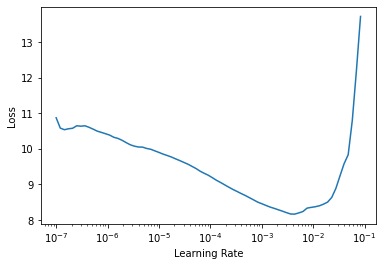

In [ ]:
#모델 구성 후 fine_tuning 진행
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr=learn.lr_find()
print(lr)
learn.fine_tune(6)

#21분 소요

In [ ]:
#구성하고 학습한 모델을 저장 , 모델 경로에 주의
torch.save(model, f'/gdrive/My Drive/Colab Notebooks/corpus_data/model.pt')

## Fine-Tuning 된 모델 사용

In [ ]:
#이미 학습된 모델 및 KoGPT2 tokenizer 불러오기

#=============================================================================
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>')
model = torch.load('/gdrive/My Drive/Colab Notebooks/corpus_data/model.pt',map_location=torch.device('cpu'))
#=============================================================================

In [ ]:
#make_line(키워드 혹은 가사 생성시 사용할 미끼가사 , 문장의 길이)
#output = KoGPT2로 생성한 가사

def make_line(rhyme_word,word_len):
  prompt= rhyme_word
  prompt_ids = tokenizer.encode(prompt)
  inp = tensor(prompt_ids)[None]
  preds = model.generate(inp,
                           max_length=word_len,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
  return tokenizer.decode(preds[0].cpu().numpy())

In [ ]:
def make_verse_seq(key_word,verse_maxlen,
               max_rhyme_hit,min_rhyme_hit,min_level=0):
  
  base_sim = sim_after_rhyme(key_word,max_rhyme_hit,min_rhyme_hit,min_level)
  base_sim = [[key_word]] + base_sim

  use_word = []
  verse = ""
  verse_idx = 1

  for i in base_sim:
    if i[0] not in use_word:
      ori_verse = verse
      verse += (" " + i[0])
      use_word.append(i[0])
      print("now use_word... : ",use_word)
      check = True

      for p in range(len(verse)+1,verse_maxlen):
        make = kss.split_sentences((make_line(verse,p)))
        if len(make) > verse_idx:
          verse = make_line(verse,p-1)
          verse_idx += 1
          check = False
          break
      
      if check:
        verse = ori_verse
        use_word.pop(-1)

  return verse



In [ ]:
def make_verse_not_seq(key_word,verse_maxlen,one_verse_len,
               max_rhyme_hit,min_rhyme_hit,min_level=0):
  
  base_sim = sim_after_rhyme(key_word,max_rhyme_hit,min_rhyme_hit,min_level)
  base_sim = [[key_word]] + base_sim
  print(base_sim)

  use_word = []
  check = 0
  ori_verse =""

  for i in base_sim:
    if i[0] not in use_word:
      verse = i[0] + " "
      use_word.append(i[0])
      print("now use_words... : ",use_word)
      check += 1

      for p in range(len(verse)+1,one_verse_len):
        make = kss.split_sentences((make_line(verse,p)))
        if len(make) >= 2:
          parsing_verse = make_line(verse,p-1)
          ori_verse += (" " + parsing_verse)
          print(parsing_verse)
          break
      
      if check >= verse_maxlen:
        break

  print(ori_verse)
  return ori_verse

In [ ]:
def make_verse_choose(key_word,verse_maxlen,one_verse_max_len,
               max_rhyme_hit,min_rhyme_hit,min_level=0):
  
  base_sim = sim_after_rhyme(key_word,max_rhyme_hit,min_rhyme_hit,min_level)
  base_sim = [[key_word]] + base_sim

  use_word = []
  check = 0
  ori_verse = []

  for i in base_sim:
    if i[0] not in use_word:
      verse = i[0] + " "
      use_word.append(i[0])
      print("now using_words... : ",use_word)

      for p in range(len(verse)+1,one_verse_max_len):
        make = kss.split_sentences((make_line(verse,p)))
        if len(make) >= 2 or p == one_verse_max_len-1:
          parsing_verse = make_line(verse,p-1)

          parsing_list = list(parsing_verse.split(" "))
          parsing_len = len(parsing_list)
          print("========================")
          print("현재가사 : ")
          for gasa in ori_verse:
            print(gasa)
          print("========================")
          print("가장 적절한 가사 번호 선택, 마음에 들지 않으면 -1로 스킵")
          print("========================")
          for k in range(1,parsing_len+1):
            result = ' '.join(s for s in parsing_list[0:k])
            stdout.write("선택 %d : %s \n" % (k,result))
          print("========================")
          cho = int(input())
          if cho != -1:
            ori_verse.append(' '.join(s for s in parsing_list[0:cho]))
            stdout.flush()
            check += 1
          break
      
      if check >= verse_maxlen:
        break

  return ori_verse

In [ ]:
def make_verse_choose_without_word2vec(
    key_word,verse_maxlen,one_verse_max_len,
    max_rhyme_hit,min_rhyme_hit,min_level=0):
  
  a,b,c = score_rank(key_word,max_rhyme_hit,min_rhyme_hit)
  base_sim =  a + b + c
  base_sim.sort(key=lambda x : x[1],reverse=True)
  base_sim = [[key_word]] + base_sim

  use_word = []
  check = 0
  ori_verse = []

  for i in base_sim:
    if i[0] not in use_word:
      verse = i[0] + " "
      use_word.append(i[0])
      print("now using_words... : ",use_word)

      for p in range(len(verse)+1,one_verse_max_len):
        make = kss.split_sentences((make_line(verse,p)))
        if len(make) >= 2 or p == one_verse_max_len-1:
          parsing_verse = make_line(verse,p-1)

          parsing_list = list(parsing_verse.split(" "))
          parsing_len = len(parsing_list)
          print("========================")
          print("현재가사 : ")
          for gasa in ori_verse:
            print(gasa)
          print("========================")
          print("가장 적절한 가사 번호 선택, 마음에 들지 않으면 -1로 스킵")
          print("========================")
          for k in range(1,parsing_len+1):
            result = ' '.join(s for s in parsing_list[0:k])
            stdout.write("선택 %d : %s \n" % (k,result))
          print("========================")
          cho = int(input())
          if cho != -1:
            ori_verse.append(' '.join(s for s in parsing_list[0:cho]))
            stdout.flush()
            check += 1
          break
      
      if check >= verse_maxlen:
        break

  return ori_verse

In [ ]:
#=============================================================================
#모든 쉘 실행 후 Colab or jupyter notebook 상에서 사용
#=============================================================================

#함수 설명

#make_line(rhyme_word,word_len)
  #rhyme_word : 키워드 혹은 가사 생성시 사용할 미끼가사
  #word_len : 전체 가사의 길이

  #output : 라임을 고려하지 않은 일반적인 가사

#make_verse_seq(key_word,verse_maxlen,
               #max_rhyme_hit,min_rhyme_hit,min_level=0)
  #key_word : 가사에 처음으로 사용할 단어
  #verse_maxlen : 전체 가사의 길이
  #max_rhyme_hit : 사용할 단어들의 최대 라임 HIT
  #min_rhyme_hit : 사용할 단어들의 최소 라임 HIT
  #min_level=0 : 사용할 단어들의 word2vec 최소 유사도 ( 미만이면 사용 X )

  #시퀀스로 가사를 생성하는 방식
  #한단어로 가사를 만들고 그 위에 덮어 씌우는 방식

#make_verse_not_seq(key_word,verse_maxlen,one_verse_len,
               #max_rhyme_hit,min_rhyme_hit,min_level=0)
  #key_word : 가사에 처음으로 사용할 단어
  #verse_maxlen : 전체 가사의 줄의 개수
  #one_verse_len : 허용할 가사 한줄의 최대 길이
  #max_rhyme_hit : 사용할 단어들의 최대 라임 HIT
  #min_rhyme_hit : 사용할 단어들의 최소 라임 HIT
  #min_level=0 : 사용할 단어들의 word2vec 최소 유사도 ( 미만이면 사용 X )

  #여러 단어들을 통해 가사를 각각 한 줄씩 만들고
  #이후 합치는 방법으로 진행

# make_verse_choose_without_word2vec(
    #key_word,verse_maxlen,one_verse_max_len,
    #max_rhyme_hit,min_rhyme_hit,min_level=0)

  #key_word : 가사에 처음으로 사용할 단어
  #verse_maxlen : 전체 가사의 줄의 개수
  #one_verse_len : 허용할 가사 한줄의 최대 길이
  #max_rhyme_hit : 사용할 단어들의 최대 라임 HIT
  #min_rhyme_hit : 사용할 단어들의 최소 라임 HIT
  #min_level=0 : 사용할 단어들의 word2vec 최소 유사도 ( 미만이면 사용 X )

  #가사 생성은 모델이 진행하지만 , 선택은 사람이 할 수 있음
  #인공지능이 생성한 여러가지 가사들 중 사용자가 원하는 가사를 선택
  #한줄 한줄 이어나가 최종적인 가사 전체를 구성

#=============================================================================